In [1]:
from astrosite_dataset import AstrositeDataset

dataset_path = '../dataset/recordings'
target_id = 37867
dataset = AstrositeDataset(dataset_path, split=str(target_id))

In [2]:
print(dataset[0]['events'][:5])
print(dataset[0]['labelled_events'][:5])

[(  0,  175, 174,  True) (456,  895, 275, False) (568, 1145, 413, False)
 (596, 1093, 246, False) (644,  462, 284,  True)]
[(  0, 175, 174,  True,  0) (728, 177, 173,  True, 26)
 (775, 177, 171,  True, 25) (793, 184, 172,  True,  0)
 (950, 427, 467,  True,  0)]


In [3]:
from spinnaker_loader import EventsLoader

train_loader = EventsLoader(dataset, bins_per_sample=8, sample_time=1000000)

Collect 9 samples that have only 1 satellite label, and only retain the events that are labelled as that satellite.

In [17]:
samples = []
n_samples = 9

for sample in dataset:
    labels = sorted(list(set(sample['labelled_events']['label'])))
    if labels[0] < -1:
        print(f"Skipping sample with labels {labels}")
        continue
    
    events = sample['labelled_events']
    sat_events = events[events['label'] == -1]
    if len(sat_events) > 320:
        samples.append(sat_events)
    if len(samples) >= n_samples:
        break

Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [19]:
len(samples)


9

In [20]:
import numpy as np

side_length = np.sqrt(n_samples).astype(int)
max_x = 1280
max_y = 720

for i in range(side_length):
    for j in range(side_length):
        index = i*side_length+j
        x_shift = max_x*j
        y_shift = max_y*i
        samples[index]['x'] += x_shift
        samples[index]['y'] += y_shift

merged_events = np.concatenate(samples)
merged_events = np.sort(merged_events, order='t')

In [21]:
import event_stream

encoder = event_stream.Encoder('merged_events.es', 'dvs', 1280*side_length, 720*side_length)

In [22]:
encoder.write(merged_events)

In [23]:
target_sat_events = []

for sample in dataset:
    labels = sorted(list(set(sample['labelled_events']['label'])))
    if labels[0] < -1:
        print(f"Skipping sample with labels {labels}")
        continue
    
    events = sample['labelled_events']
    sat_events = events[events['label'] == -1]
    if len(sat_events) > 320:
        target_sat_events.append(sat_events)

Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [24]:
len(target_sat_events)

9

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jules/Documents/satellite-characterization')
import torch
import torchvision
import numpy as np
from pathlib import Path
from tqdm import tqdm
from astrosite_dataset import build_merge_dataset, MergedDataset
from models.scnn_tracker import MotionTrackerStaticSNN

/home/jules/miniconda3/envs/satellite/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = '/home/jules/Documents/filtered_dataset/recordings'
target_list = ['50574']
dataset = build_merge_dataset(
        dataset_path, split=['50574'], metadata_paths=[None, None])

tau_mem1 = 0.2
tau_mem2 = 0.4
tau_mem3 = 0.6
train_mem = False

In [3]:
net = MotionTrackerStaticSNN(144, 256,  tau_mem1, tau_mem2, tau_mem3,
        train_mem=train_mem)
net.load_state_dict(torch.load('./data/dynamic_tau/model_nocrop.pt'))

device = torch.device("cuda") if torch.cuda.is_available() \
    else torch.device("cpu")
print("Using device:", device)
net = net.to(device)

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..116.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..116.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..116.0].


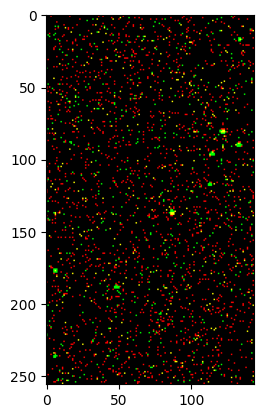

In [16]:
import matplotlib.animation as animation

input_pictures = []
output_pictures = []

fig, ax = plt.subplots()

def update(i):
    im.set_array(input_pictures[i])
    return im, 

for j in range(1):
    input, target = dataset[j]
    for i in range(input.shape[0]) :
        input_picture = np.concatenate((input[i], np.zeros((1,144,256))), axis=0).swapaxes(0,2)
        input_pictures.append(input_picture)
    #cv2.imshow("satellite",target[0])
    output = net(torch.from_numpy(input).type(torch.float).unsqueeze(0).to(device))
    sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
    #cv2.imshow("prediction",sum_output)
    #cv2.waitKey(10)

# Set the initial image
im = ax.imshow(input_pictures[0], animated=True)

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(input_pictures), interval=2, blit=True,repeat_delay=1,)

# Show the animation
plt.show()

animation_fig.save("animated_input.gif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..122.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..32.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..42.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..24.6].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..33.9].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..31.6].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..65.0].


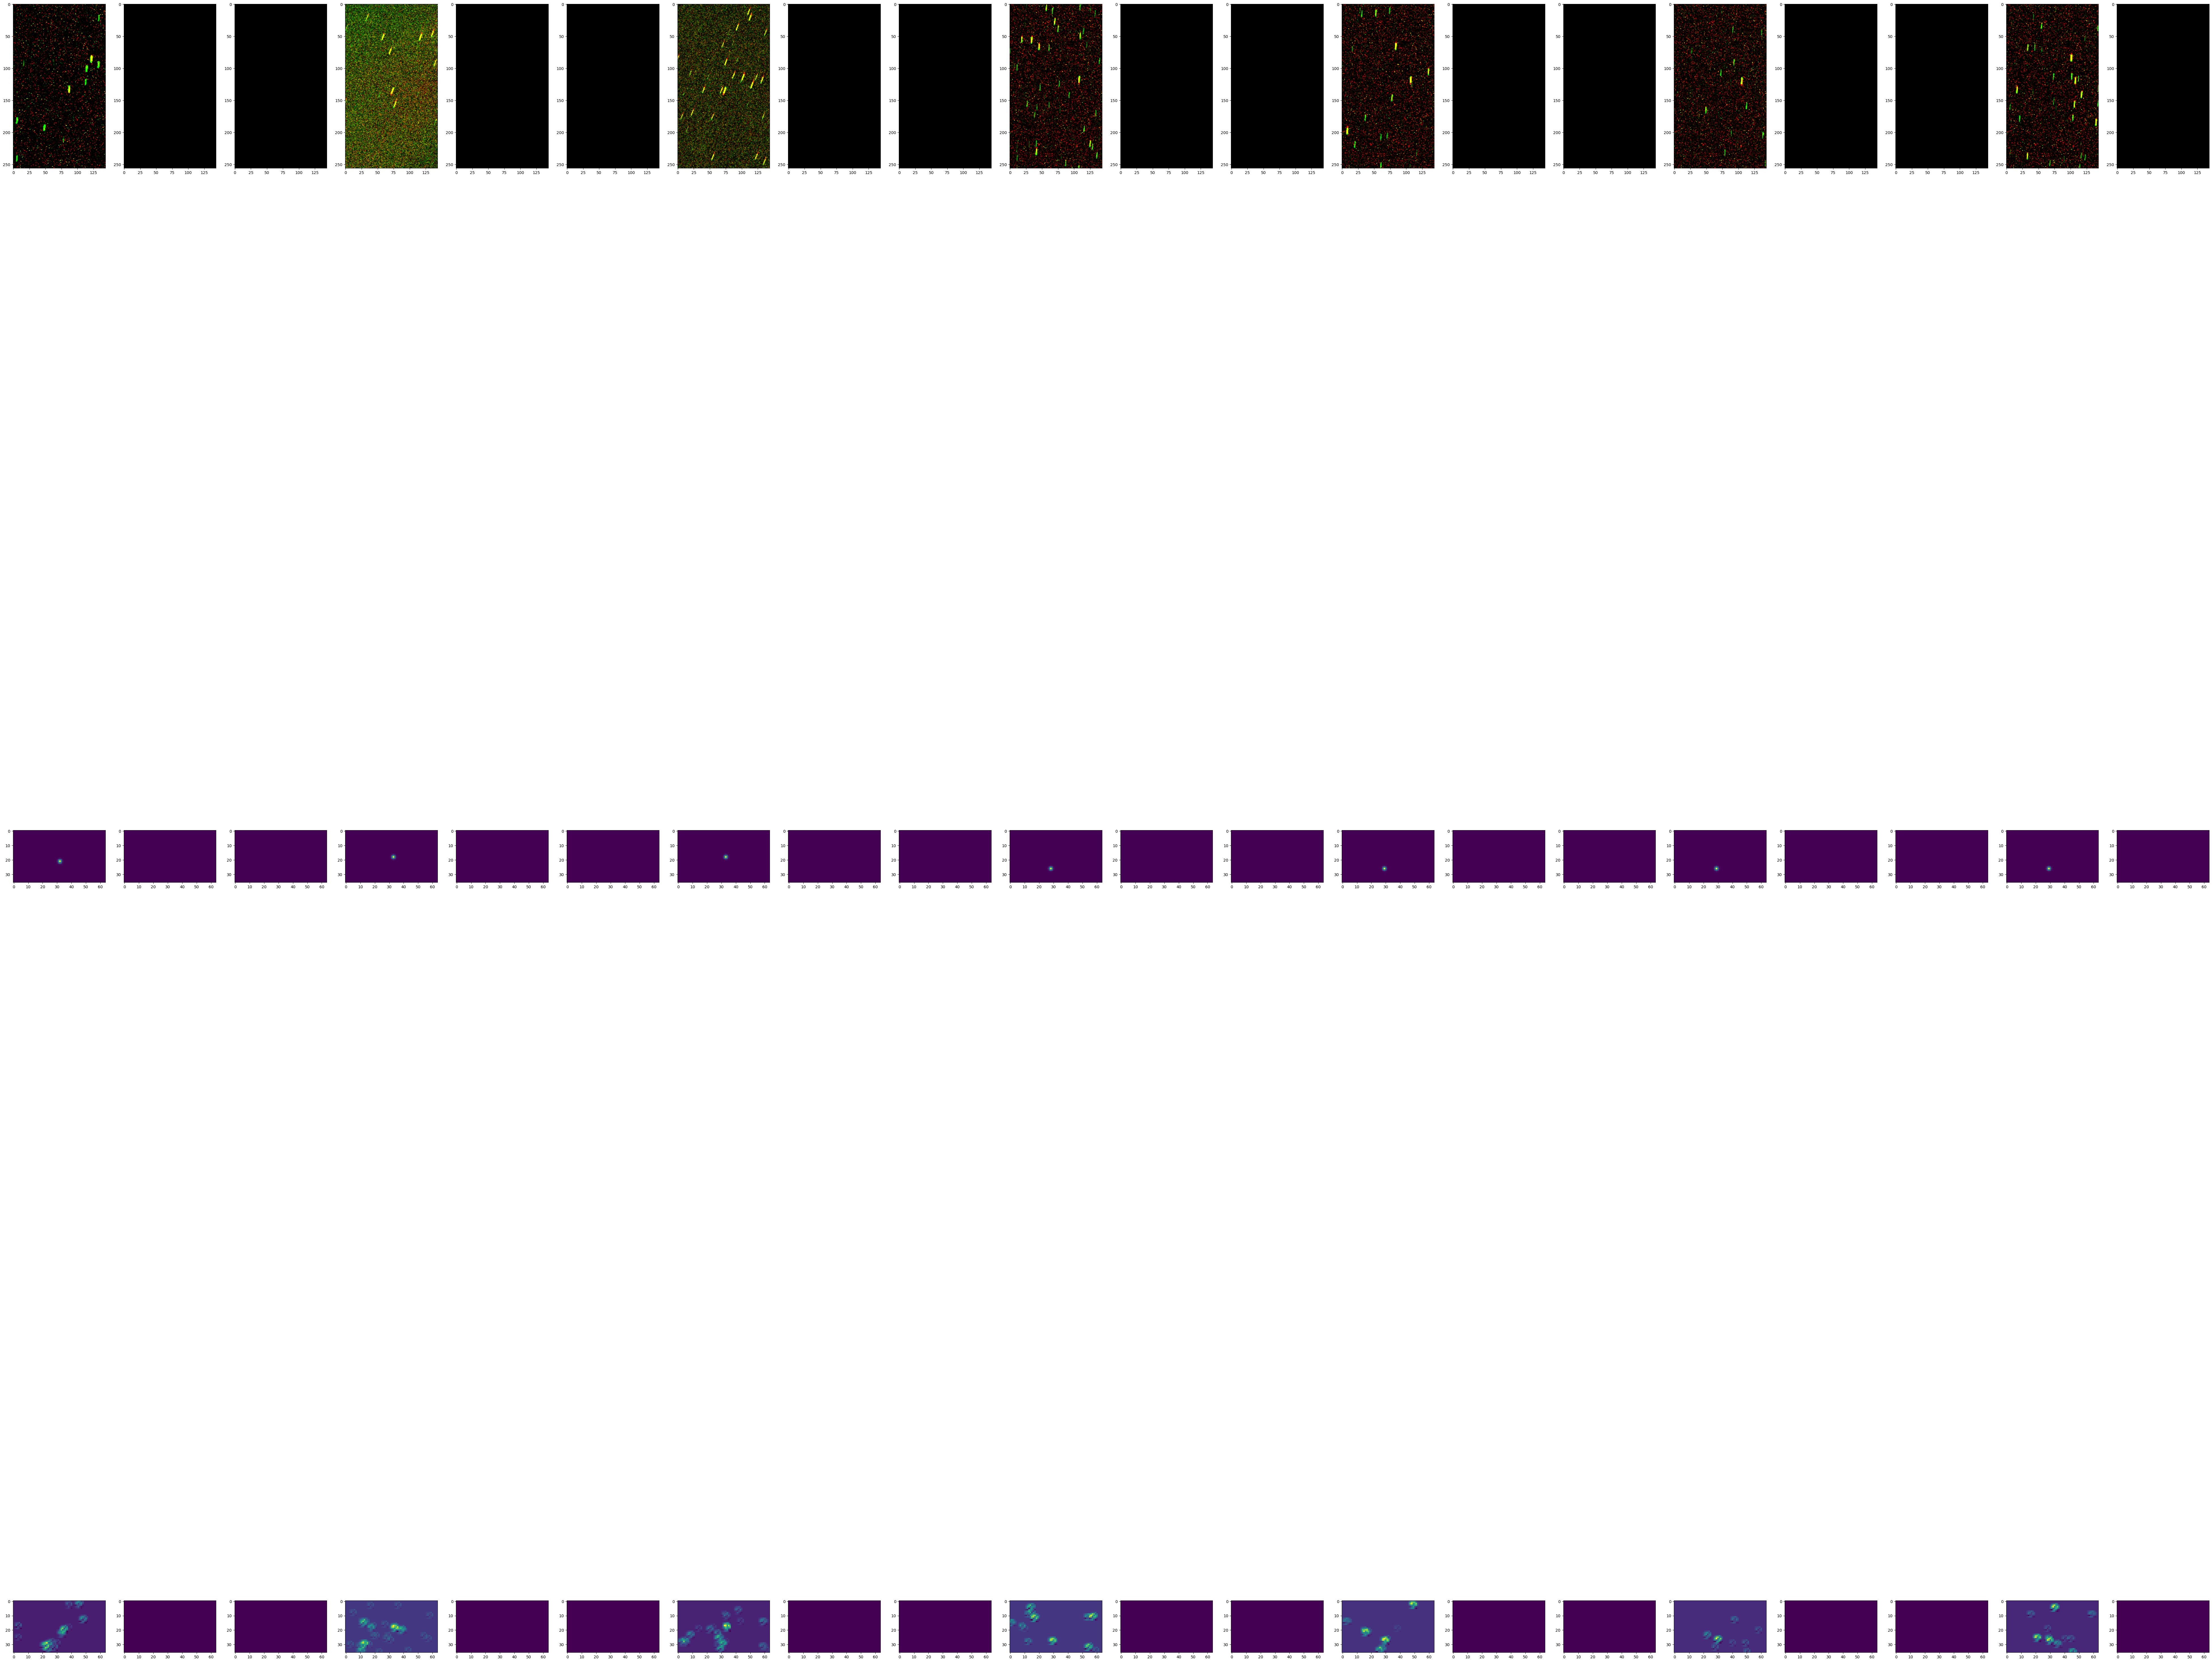

In [4]:
fig, axs = plt.subplots(3,20, figsize=(100,100))

for i in range(20) :
    input, target = dataset[i]
    if np.max(input)>0:
        norm_input = np.mean(input,axis=0)
    else :
        norm_input = np.mean(input, axis=0)
    input_picture = np.concatenate((norm_input, np.zeros((1,144,256))), axis=0).swapaxes(0,2)
    axs[0,i].imshow(input_picture)
    axs[1,i].imshow(target[0])
    output = net(torch.from_numpy(input).type(torch.float).unsqueeze(0).to(device))
    sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
    axs[2,i].imshow(sum_output)
plt.show()

In [22]:
acc = 0
no_detection = 0
no_satellite = 0
f_p = 0
f_n = 0
for j in range(len(dataset)) :
    detection_input, detection_target = dataset[j]
    detection_output = net(torch.from_numpy(detection_input).type(torch.float).unsqueeze(0).to(device))
    #print(np.max(detection_output.detach().cpu().numpy()))
    #print(np.max(detection_target))
    if np.max(detection_output.detach().cpu().numpy()) < 0.068 and np.max(detection_target) == 0:
        no_detection += 1
        no_satellite += 1
        acc+=1
    elif np.max(detection_output.detach().cpu().numpy()) < 0.068:
        f_n += 1
    elif np.max(detection_target) == 0 :
        f_p += 1
    else :
        acc +=1
print("Detection_accuracy:",acc/len(dataset))
print("False positive:",f_p/len(dataset))
print("False negative:",f_n/len(dataset))
print(no_detection/len(dataset))
print(no_satellite/len(dataset))
    


Detection_accuracy: 0.8632478632478633
False positive: 0.13675213675213677
False negative: 0.0
0.6666666666666666
0.6666666666666666
